# Testing for running on loaded/prepped waveforms and intro data stored as pickles

In [1]:
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.geodetics.base import kilometers2degrees as km2deg
from compress_pickle import dump,load  # reading/writing compressed pickles
import os
from rtergpy.waveforms import wave2energytinc
from rtergpy.waveforms import get_respinv, get_neicwaves,etime2name,process_waves,bc10,tstar
from rtergpy.waveforms import gttP,gmeanCut,estFgPcorrect,loadwaves
import shutil
import rtergpy.waveforms
import pandas as pd
import glob
import sys
from obspy.signal.freqattributes import spectrum
from scipy.fftpack import rfft,fft 
import numpy as np
from numpy import sin,cos,exp,log10,pi,abs,sqrt
import matplotlib.pyplot as plt
### Get Data
eventname='2021072300'  # data pulled py Example_rapidNEICeventdata.py
eloc = [13.80,120.50,104]
etime= UTCDateTime(2021,7,23,20,49,00)   # recent M7 in eastern Indonesia
#get new data
#st,df=getwaves(eloc,etime)
# get locally stored data
iter='00'
st,df=loadwaves(eventname) # assumes iteration zero if not included

In [ ]:
# checking event information
#ntr=91-8
ntr=40
tr=st[ntr].copy();

print(tr.stats);
#print(tr.stats);
t1cut=tr.stats.phasePtime-10
t2cut=t1cut+300
trslice=tr.slice(t1cut,t2cut)
print(trslice);
trslice.plot();

# testing energy calculation

In [ ]:
#waveform window around P-wave
startEtime=-5
Ewindow=300
ntr=40
elat,elon,edepth=eloc
#additional event info
phi,delta,lmbda=[0, 20, 90]  # strike, dip, rake
phi,delta,lmbda=[109,45,50]  # from gCMT

#site conditions
pvel_site=7000.
rho_site=3000.

pmin=0.5; pmax=70;  # period range in seconds
fmin=1/pmax ; fmax=1/pmin; # freq range in Hz

E=[];
#for i in range(0,len(st)-1):
for i in [ntr]:
  rearth=6371e3
  qbc=15.6 #q-factor from B&C
  avfpsq=(4/15)
  aob=sqrt(3)  # alpha over beta
  tr=st[i].copy();
  edistdeg=tr.stats.distdeg
  #ptoa=tr.stats.ptoa
  eqaz=tr.stats.az
  tr.resample(10)
  t1cut=tr.stats.phasePtime-startEtime 
  t2cut=t1cut+Ewindow
  trslice=tr.slice(t1cut,t2cut)
  print(trslice);
  
  tr=process_waves(trslice,freqmin=fmin,freqmax=fmax)
  #tr=trslice
  trf=fft(tr)
  # # recreating obspy.freqatributes.spectrum
  n1=0; n2=len(tr)
  n=n2-n1
  srate=tr.stats.sampling_rate
  dt=1/srate    
  f=np.linspace(0,srate/2,n)
  
  # for testing run the following in the data directory:
  # printf "II.WRAB_.00.BHZ.SAC\nII.WRAB_.00.BHZ.SAC.pz\n300\n1\n"  | /home/jconvers/EQerg/CWBerg/src/nergy_wprep.cwb.wderivs_outputfft
  # integration prep 
  sinu=0
  for j in range(0,len(f)-1):
    if (f[j]>fmin) & (f[j]<=fmax):
      sinu += abs(trf[j])**2*exp(2*pi*f[j]*tstar(f[j]))
  sinu=sinu*2*pi*dt/n
  Estar=rho_site*pvel_site*sinu  # didn't divide by pi, as this isn't called for in discrete Parservel's theorem
  p,g,rpz,fp,fpp,fsp,PP,SP=bc10(edistdeg,edepth,phi,delta,lmbda,eqaz,rho_site,pvel_site,rearth)
  geomsp=g*rpz
  #print("g=",g)
  #print("rpz",rpz)
  Energy=Estar*(rearth/geomsp)**2
  FgP2=fp**2+(fpp*PP)**2+(2/(3*aob))*qbc*((SP*fsp)**2)
  #print("fp,fpp,PP,aob,qbc,SP,fsp",fp,fpp,PP,aob,qbc,SP,fsp)
  if (FgP2<0.2):
    FgP2=0.2  # avoid blow-up
  Nergy=Energy*4*pi*(avfpsq/FgP2)*(1+qbc) # true energy for mech
  # distance-based FgP2estimate
  estFgP2=estFgPcorrect(edistdeg)
  estNergy=Energy*4*pi*(avfpsq/estFgP2)*(1+qbc) # true energy for mech
  print("sinu,Estar,estNergy = ", sinu,Estar,estNergy)
  E.append(estNergy)   

#E.remove(min(E))  # until I get a SNR discriminent 

#plt.plot(E,'r+');
#plt.yscale('log');
from scipy.stats import gmean 

print("geometric mean = ",gmean(E))


# Testing incremental Energy (using time-domain)

estimated energy: 5.92e+14 J


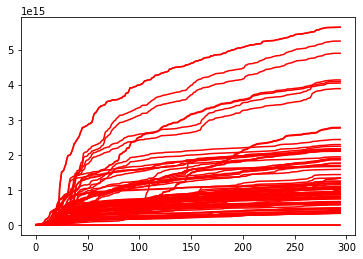

In [2]:
#waveform window around P-wave
ntr=40
tstart=-5  # relative to P
tlength=300 # after tstart
tstep=1 # incriment
window=[tstart,tlength]
elat,elon,edepth=eloc
#additional event info
phi,delta,lmbda=[0, 20, 90]
foc=[phi,delta,lmbda]

#site conditions
pvel_site=7000.
rho_site=3000.

pmin=0.5; pmax=70;  # period range in seconds
fmin=1/pmax ; fmax=1/pmin; # freq range in Hz
#Ergs=wave2energy(st[ntr].copy(),[[fmin,fmax],window],[eloc,foc],[pvel_site,rho_site])
for tr in st:
    Ergs=wave2energytinc(tr,[[fmin,fmax],window],[eloc,foc],[pvel_site,rho_site])
    plt.plot(Ergs[0],'r-')
#print(EstErg*2*pi,TruErg,EFgP2,FgP2)
print("estimated energy: %.2e J" %(Ergs[0][-1]))
plt.show;

In [3]:
%%time 
fbands=[[fmin,fmax],[0.5,fmax]]
window=[-5,300]
step=1

from rtergpy.waveforms import stepthroughwaves 
edf=stepthroughwaves(st,[fbands,window,step],[eloc,foc],[pvel_site,rho_site])

100%|██████████| 95/95 [00:10<00:00,  9.35it/s]

CPU times: user 10.1 s, sys: 75.5 ms, total: 10.2 s
Wall time: 10.2 s


In [4]:
edf.head()

,netstatchan,fband,waveparams,eEtinc,corrections
0,IC.BJT.00.BHZ,"[0.014285714285714285, 2.0]","[[-5, 300], 1]","[[127315348355.0, 156368291916.0, 187987090024...","[(1.01958069659, 0.225783625944, 4.51574241636)]"
1,IC.BJT.00.BHZ,"[0.5, 2.0]","[[-5, 300], 1]","[[1668400664.87, 2654168425.61, 3460660095.2, ...","[(1.01958069659, 0.225783625944, 4.51574241636)]"
2,IC.HIA.00.BHZ,"[0.014285714285714285, 2.0]","[[-5, 300], 1]","[[1035651192.91, 1946121240.18, 2397987427.6, ...","[(0.987728479639, 0.337546896056, 2.92619630392)]"
3,IC.HIA.00.BHZ,"[0.5, 2.0]","[[-5, 300], 1]","[[205785050.078, 262532704.853, 366855856.232,...","[(0.987728479639, 0.337546896056, 2.92619630392)]"
4,IC.LSA.00.BHZ,"[0.014285714285714285, 2.0]","[[-5, 300], 1]","[[4254272482.43, 4651113911.58, 31503868666.3,...","[(1.00087660699, 0.373838405742, 2.67729744085)]"


In [ ]:
%%time 
Ergs2=wave2energyinc(st[40].copy(),[[fmin,fmax],window],[eloc,foc],[pvel_site,rho_site])
print(Ergs2)

In [ ]:
from rtergpy.waveforms import wave2energy
#waveform window around P-wave
tstart=-5  # relative to P
tlength=300 # after tstart
tstep=1 # incriment
window=[tstart,tlength]
elat,elon,edepth=eloc
#additional event info
phi,delta,lmbda=[0, 20, 90]
phi,delta,lmbda=[109,45,50]  # from gCMT

foc=[phi,delta,lmbda]

#site conditions
pvel_site=7000.
rho_site=3000.

pmin=0.5; pmax=70;  # period range in seconds
fmin=1/pmax ; fmax=1/pmin; # freq range in Hz
E=np.empty((0,4))
for i in range(0,len(st)-1):
    thisE=wave2energy(st[i].copy(),[[fmin,fmax],window],[eloc,foc],[pvel_site,rho_site])
    E=np.append(E,np.array([thisE]),axis=0)


In [ ]:

#E.remove(min(E))  # until I get a SNR discriminent 
plt.plot(E[:,1],'r+');
plt.yscale('log');
from scipy.stats import gmean 

cutoff=15
Emean1=gmean(E[:,1])
print("original emean: ",Emean1)
Ekeep=E[E[:,1]>Emean1/cutoff]
Ekeep=Ekeep[Ekeep[:,1]<Emean1*cutoff]
Emean2=gmean(Ekeep[:,1])
print("new emean: ",Emean2)
print("From ",len(E)," to ",len(Ekeep)," observations.")
plt.plot(Ekeep[:,1],'r+');
plt.yscale('log');



In [ ]:
from rtergpy.waveforms import gmeanCut

EgmeanTrue,ETrue=gmeanCut(E[:,1],cutoff=50)
EgmeanEst,EEst=gmeanCut(E[:,0],cutoff=50)
print(EgmeanEst,EgmeanTrue)

plt.plot(ETrue,'bo',EEst,'r+');
plt.yscale('log');
plt.legend;

#Testing energy in synthetic solutions.  
1. integrate energy in time-series
    
    $E=\int x(t)^2 dt$
1. integrate energy in f-domain
    
    $E=\int x(f)^2 df$

In [ ]:
ntr=40
tr=st[ntr].copy();
#tr.decimate(4)

#print(tr);
#print(tr.stats);
t1cut=tr.stats.phasePtime-10
t2cut=t1cut+300
trslice=tr.slice(t1cut,t2cut)
print(trslice);

pmin=0.5; pmax=70;  # period range in seconds
fmin=1/pmax ; fmax=1/pmin; # freq range in Hz
tr=process_waves(trslice,freqmin=fmin,freqmax=fmax)
trf=fft(tr)
# # recreating obspy.freqatributes.spectrum
n1=0; n2=len(tr)
n=n2-n1
srate=tr.stats.sampling_rate
dt=1/srate    

f=np.linspace(0,srate/2,len(tr))
df=f[2]-f[1];

# integrate time domain (all)
intd=0
for i in range(0,n-1):
  intd+=dt*tr[i]**2

intf=0
for j in range(0,n-1):
  intf += dt/n*np.abs(trf[j])**2

print("intd = ",intd)
print("intf = ",intf)

# the below are equivelent

print("sum(tr**2) = ", dt*np.sum(tr.data**2))
print("sum(fft(tr)**2)/N) = ",dt/n*np.sum(np.abs(fft(tr))**2))
print("2*sum(rfft(tr)**2)/N) = ",2*dt/n*np.sum(np.abs(rfft(tr))**2)) # add factor of 2x since only shows real comp.
print(srate,df,dt,n)


tr.plot();
# plot only real part of spectrum
n2=int((n-1)/2)
plt.plot(f[0:n2],abs(trf[0:n2]))
plt.xscale('log') ; plt.yscale('log')
